In [1]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    f1_score, 
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('../../dataset/classification/train.csv')
test_data = pd.read_csv('../../dataset/classification/test.csv')

Delimo ulazne i izlazne atribute. Za `X_train / X_test` uzimamo sve instance sa atributima do poslednjeg. Za `Y_train / Y_test` uzimamo sve instance i to samo poslednji atribut.

In [3]:
X_train = train_data.iloc[:, :-1]
Y_train = train_data.iloc[:, -1:]

X_test = test_data.iloc[:, :-1]
Y_test = test_data.iloc[:, -1:]

Delimo `X_train` podatke na podatke za treniranje modela i podatke za validaciju modela

In [4]:
(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.20, random_state=42, stratify=Y_train)

In [5]:
X_train.shape, X_val.shape, X_test.shape

((30782, 3000), (7696, 3000), (8848, 3000))

Vrsimo prilagodjavanje modela na osnovu alfa parametra. Trazimo najbolje $ \alpha $ za nas model u opsegu [0, 3] sa korakom 0.1

In [6]:
def score_model(Y_true: pd.DataFrame, Y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    accuracy = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    
    return (precision, recall, accuracy, f1)

In [7]:
alphas = np.arange(0, 3, 0.1)
results = {}

for alpha in alphas:
    force_alpha = True if alpha == 0 else False
    mnb = MultinomialNB(alpha=alpha, force_alpha=force_alpha)
    mnb.fit(X_train, Y_train.values.ravel())
    
    Y_pred = mnb.predict(X_val)
    
    (precision, recall, accuracy, f1) = score_model(Y_val, Y_pred)
    results[alpha] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

/home/filip/.local/lib/python3.8/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/filip/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/filip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
precisions = [results[key]['precision'] for key in results]
recalls = [results[key]['recall'] for key in results]
accuracies = [results[key]['accuracy'] for key in results]
f1s = [results[key]['f1'] for key in results]

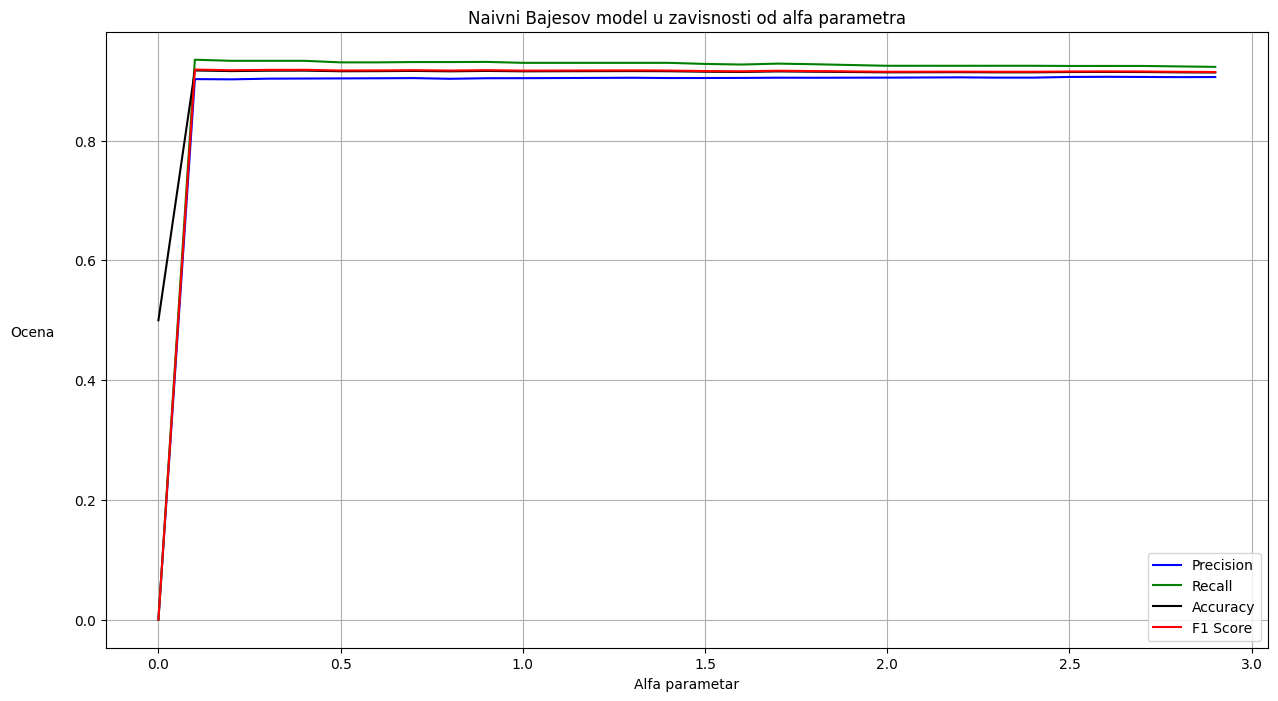

In [9]:
plt.figure(figsize=(15, 8))

plt.plot(alphas, precisions, color='blue', label='Precision')
plt.plot(alphas, recalls, color='green', label='Recall')
plt.plot(alphas, accuracies, color='black', label='Accuracy')
plt.plot(alphas, f1s, color='red', label='F1 Score')

plt.title('Naivni Bajesov model u zavisnosti od alfa parametra')
plt.xlabel('Alfa parametar')
plt.ylabel('Ocena', rotation=0, labelpad=30)
plt.grid(True)
plt.legend()

plt.show()

Malo bolji prikaz s obzirom da su modeli za $ \alpha > 0.0 $ jako slicni i teze je na skali sa parametrom $ \alpha = 0.0 $ videti razlike izmedju modela

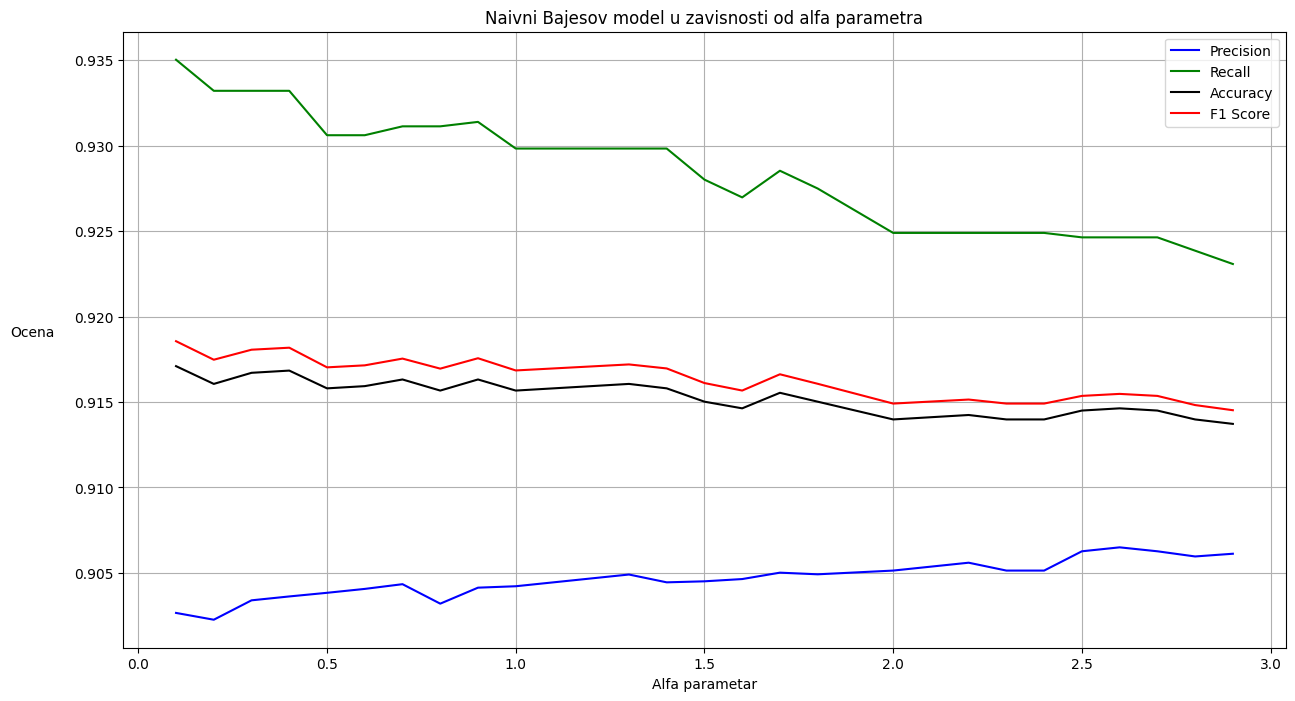

In [10]:
plt.figure(figsize=(15, 8))

plt.plot(alphas[1:], precisions[1:], color='blue', label='Precision')
plt.plot(alphas[1:], recalls[1:], color='green', label='Recall')
plt.plot(alphas[1:], accuracies[1:], color='black', label='Accuracy')
plt.plot(alphas[1:], f1s[1:], color='red', label='F1 Score')

plt.title('Naivni Bajesov model u zavisnosti od alfa parametra')
plt.xlabel('Alfa parametar')
plt.ylabel('Ocena', rotation=0, labelpad=30)
plt.grid(True)
plt.legend()

plt.show()

Sa prethodne slike se moze videti da je za $ \alpha = 0.1 $ najbolja ocena modela

In [11]:
best_alpha = 0
best_accuracy = results[0]['accuracy']
for alpha in results:
    if results[alpha]['accuracy'] > best_accuracy:
        best_alpha = alpha
        best_accuracy = results[alpha]['accuracy']

print(f'Najbolji alfa parametar: {best_alpha}')
print(f'Precision: {results[best_alpha]["precision"]}')
print(f'Recall: {results[best_alpha]["recall"]}')
print(f'Accuracy: {results[best_alpha]["accuracy"]}')
print(f'F1: {results[best_alpha]["f1"]}')

Najbolji alfa parametar: 0.1
Precision: 0.9026593075765178
Recall: 0.935031185031185
Accuracy: 0.9170997920997921
F1: 0.9185601225427622


Treniramo model na osnovu najboljeg $ \alpha $ parametra i prikazujemo rezultate

In [12]:
best_mnb = MultinomialNB(alpha=best_alpha, force_alpha=False)
best_mnb.fit(X_train, Y_train.values.ravel())

Y_pred = best_mnb.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)

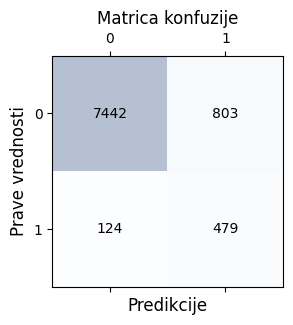

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predikcije', fontsize=12)
plt.ylabel('Prave vrednosti', fontsize=12)
plt.title('Matrica konfuzije', fontsize=12)
plt.show()

In [17]:
(precision, recall, accuracy, f1) = score_model(Y_test, Y_pred)
print(f'Za alfa parametar {best_alpha} ocene su sledece:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1: {f1}')

Za alfa parametar 0.1 ocene su sledece:
Precision: 0.3736349453978159
Recall: 0.7943615257048093
Accuracy: 0.8952305605786618
F1: 0.5082228116710875
